<h1>Initial Setup

In [ ]:
!pip install mlrun

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Set The data and artifacts paths
from mlrun import mlconf


mlconf.dbpath = 'Mention The Path For DB (Can be the path of your Working Directory)'
mlconf.artifact_path = 'path_same_as_db/Data'


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#Initialising The Project

from os import path
import mlrun

project_name_base = 'suicide-pred' # Mention Your Project Name Here

project_name, artifact_path = mlrun.set_environment(project=project_name_base, user_project=True)

print(f'Project name: {project_name}')
print(f'Artifact path: {artifact_path}')

Project name: suicide-pred-root
Artifact path: /content/drive/MyDrive/Hackathon/Data


<h1>MLRun Functions

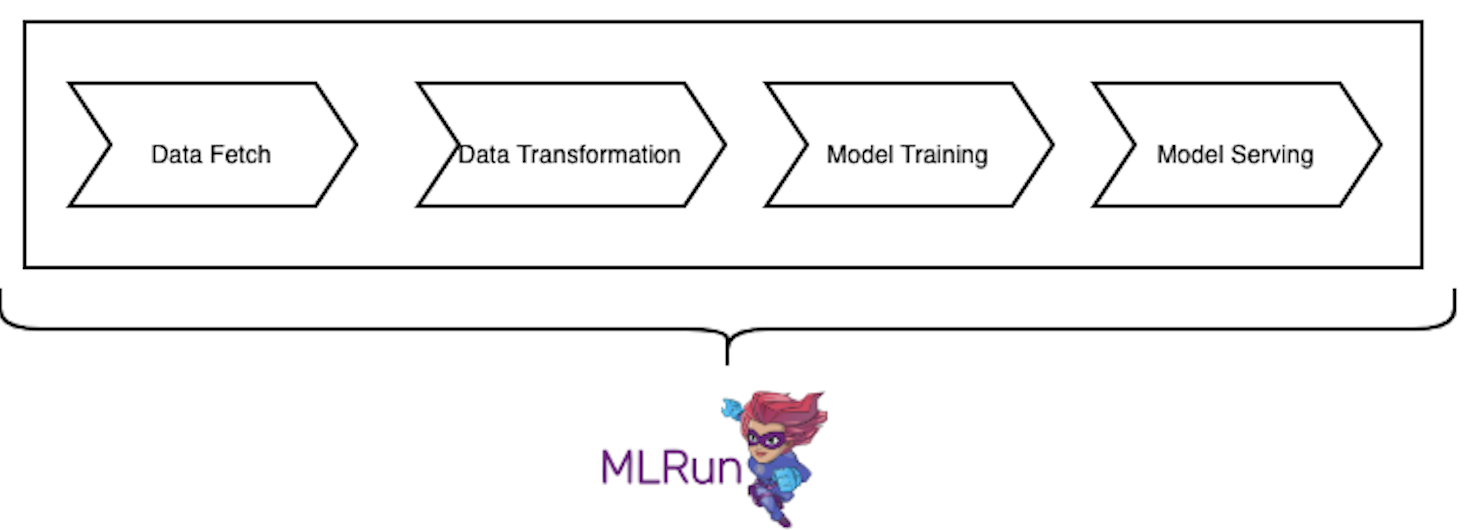

<b> The MLRun Pipeline Consists of Four Steps as Dipicted in Figure Above

In [3]:
# nuclio: start-code

<h4> Importing the Libraries

In [4]:
!pip install pymongo[srv]

import pickle
from pickle import dumps
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import nltk
from os import path
import os
import mlrun
import matplotlib.pyplot as plt
from mlrun.artifacts import PlotArtifact
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

from pymongo import MongoClient
import urllib
import sys
import pandas as pd
import pymongo
import json
import os

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h4> Reading the Data From MongoDB and storing it as a CSV

In [5]:
def read_content():
    m_client = pymongo.MongoClient("Mention The Link of Your MongoDB Client Here")
    db = m_client.test


    #m_client = pymongo.MongoClient("mongodb://...")
    m_db = m_client["suicide"]
    db_cm = m_db["suicide"]
    df = pd.DataFrame.from_records(db_cm.find())
    # print('--------------------------------')
    # print()
    # print(df)
    return df

df=read_content()
df=df[['label','tweet']]

df.to_csv('Mention the Path Where You Want The Data CSV to be Stored')

In [6]:
df

label                                              tweet
0         1  my life is meaningless i just want to end my l...
1         1  muttering i wanna die to myself daily for a fe...
2         1  work slave i really feel like my only purpose ...
3         1  i did something on the 2 of october i overdose...
4         1  i feel like no one cares i just want to die ma...
...     ...                                                ...
9219      0  superneej morning bah car won t start waiting ...
9220      0  i m off too bed i gotta wake up hella early to...
9221      0  just picked up some oats from the market to ea...
9222      0   i wish we would get it the same time at the r...
9223      0                            need to sleep but cant 

[9224 rows x 2 columns]

<h4> MLRun Function To Fetch The Data

In [7]:
def fetch_data(context : MLClientCtx, data_path: DataItem):
    
    context.logger.info('Reading data from {}'.format(data_path))

    suicide_dataset = df
    
    
    target_path = path.join(context.artifact_path, 'data')
    context.logger.info('Saving datasets to {} ...'.format(target_path))

    # Store the data sets in your artifacts database
    context.log_dataset('suicide_dataset', df=suicide_dataset, format='csv',
                        index=False, artifact_path=target_path)
    

<h4> Supporting Functions for Preprocessing

In [8]:
def preprocess_tweet(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = text+' '.join(emoticons).replace('-', '') 
    return text


from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

from nltk.corpus import stopwords
stop = stopwords.words('english')


def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\(|D|P)',text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text += ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in tokenizer_porter(text) if w not in stop]
    return tokenized



vect = HashingVectorizer(decode_error='ignore', n_features=2**21, 
                         preprocessor=None,tokenizer=tokenizer)

<h4> MLRun Function for Preprocessing

In [9]:
def transform_dataset(context : MLClientCtx, data: DataItem):

  context.logger.info('Begin datasets transform')

  df = data.as_df()
  df['tweet'] = df['tweet'].apply(lambda x: preprocess_tweet(x))

  target_path = path.join(context.artifact_path, 'data')
  context.log_dataset('suicide_dataset_transformed', df=df, artifact_path=target_path, format='csv') 

  x = ['Suicidal Posts', 'Non- Suicidal Posts']
  y = [len(df[df['label']==1]), len(df[df['label']==0])]
  
  plt.bar(x, y , color ='blue',
        width = 0.4)
  
  
  plt.xlabel("Types Of Posts")
  plt.ylabel("Frequecy")
  plt.title("Frequency VS Label Graph")

  context.log_artifact(PlotArtifact('Model Comparision Graph', body=plt.figure()))   


<h4> MLRun Function to Train Multiple Models

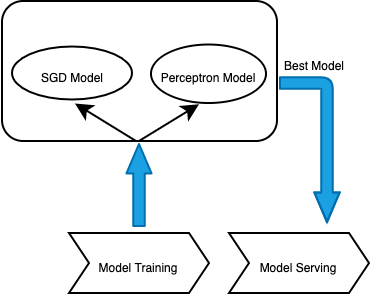

<b> The Workflow of Our Multiple Model Training Pipeline 

In [10]:
def train_model(context: MLClientCtx, input_ds: DataItem):


  context.logger.info('Begin training')
  

  clf1 = SGDClassifier(loss='log', random_state=1)
  clf2 = Perceptron(tol=1e-3, random_state=0)


  df = input_ds.as_df()
  X = df["tweet"].to_list()
  y = df['label']

  
  X_train,X_test,y_train,y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.20,
                                                  random_state=0)  
  X_train = vect.transform(X_train)
  X_test = vect.transform(X_test)

  classes = np.array([0, 1])
  context.logger.info('Training SGD Model....')
  clf1.partial_fit(X_train, y_train,classes=classes)

  context.logger.info('Training Perceptron Model....')
  clf2.partial_fit(X_train, y_train,classes=classes)

  acc1 = clf1.score(X_test, y_test)
  acc2 = clf2.score(X_test, y_test)

  # print('Accuracy SGD: %.3f' % acc1)
  # print('Accuracy Perceptron: %.3f' % acc2)

  context.log_result("Accuracy on SGD Model", round(acc1*100,2) )
  context.log_result("Accuracy on Perceptron Model", round(acc2*100,2) )
  
  
  if acc1>=acc2:
    context.logger.info('Model Selected : SGD')
    context.log_model('Suicide_Model',
                      body=dumps(clf1),
                      artifact_path=context.artifact_subpath("models"),
                      model_file="Suicide_Model.pkl")
      
    

  if acc1<acc2:
    context.logger.info('Model Selected: Perceptron')
    context.log_model('Suicide_Model',
                      body=dumps(clf2),
                      artifact_path=context.artifact_subpath("models"),
                      model_file="Suicide_Model.pkl")
    
    
  x = ['SGD Model', 'Perceptron Model']
  y = [round(acc1*100,2), round(acc2*100,2)]


  plt.bar(x, y , color ='maroon',
        width = 0.4)
  
  
  plt.xlabel("Models")
  plt.ylabel("Accuracy on Test Set")
  plt.title("Model Comparision Graph")

  context.log_artifact(PlotArtifact('Model Comparision Graph', body=plt.figure()))

  context.logger.info('End training')

<h4> MLRun Function For Model Serving

In [11]:
import numpy as np
from cloudpickle import load

class SuicideModel(mlrun.serving.V2ModelServer):
    
    def load(self):
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body):
        try:
            feats = body['inputs'][0]
            # feats = feats.decode('ISO-8859-1')
            feats = preprocess_tweet(feats)
            l = []
            l.append(feats)
            feats = vect.transform(l)
            #print('hi')
            result = self.model.predict(feats)
            return result.tolist()
        except Exception as e:
            raise Exception("Failed to predict %s" % e)

In [12]:
# nuclio: end-code

<h2>MLRun Procedure 

In [13]:
suicide_func = mlrun.code_to_function(name='suicide', kind='job', filename = 'Path of the Current Notebook')

<h3> Fetch

In [14]:
fetch_data_run = suicide_func.run(handler='fetch_data',
                               inputs={'data_path': 'Mention Path of the DATA CSV'},
                               local=True)

> 2021-07-06 10:42:11,152 [info] starting run suicide-fetch_data uid=bdc32fcd0ea144c3b1c14e8aff20bd4a DB=/content/drive/MyDrive/Hackathon
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
> 2021-07-06 10:42:11,988 [info] Reading data from /content/drive/MyDrive/Hackathon/suicidal_data1.csv
> 2021-07-06 10:42:11,993 [info] Saving datasets to /content/drive/MyDrive/Hackathon/Data/data ...


to track results use .show() or .logs() or in CLI: 
!mlrun get run bdc32fcd0ea144c3b1c14e8aff20bd4a --project suicide-pred-root , !mlrun logs bdc32fcd0ea144c3b1c14e8aff20bd4a --project suicide-pred-root
> 2021-07-06 10:42:12,232 [info] run executed, status=completed


In [15]:
fetch_data_run.outputs

{'suicide_dataset': 'store://artifacts/suicide-pred-root/suicide-fetch_data_suicide_dataset:bdc32fcd0ea144c3b1c14e8aff20bd4a'}

<h3> Transform

> 2021-07-06 10:42:12,261 [info] starting run transform_dataset uid=78364f1d3dd5401499fee36dde3293ea DB=/content/drive/MyDrive/Hackathon
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
> 2021-07-06 10:42:13,267 [info] Begin datasets transform


to track results use .show() or .logs() or in CLI: 
!mlrun get run 78364f1d3dd5401499fee36dde3293ea --project suicide-pred-root , !mlrun logs 78364f1d3dd5401499fee36dde3293ea --project suicide-pred-root
> 2021-07-06 10:42:14,406 [info] run executed, status=completed


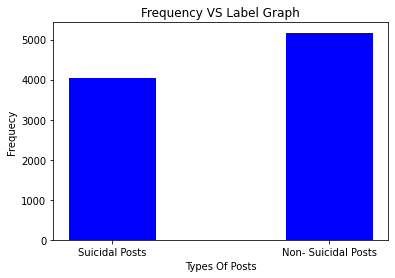

<Figure size 432x288 with 0 Axes>

In [16]:
transform_dataset_run = suicide_func.run(name='transform_dataset',
                                      handler='transform_dataset',
                                      inputs={'data': fetch_data_run.outputs['suicide_dataset']},
                                      local=True)

In [17]:
transform_dataset_run.outputs

{'Model Comparision Graph': '/content/drive/MyDrive/Hackathon/Data/Model Comparision Graph.html',
 'suicide_dataset_transformed': 'store://artifacts/suicide-pred-root/transform_dataset_suicide_dataset_transformed:78364f1d3dd5401499fee36dde3293ea'}

<h3> Train

> 2021-07-06 10:42:20,050 [info] starting run train_model uid=bcb6e214bc7c401ebd020bd9819f97be DB=/content/drive/MyDrive/Hackathon
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
> 2021-07-06 10:42:21,632 [info] Begin training
> 2021-07-06 10:42:36,756 [info] Training SGD Model....
> 2021-07-06 10:42:36,788 [info] Training Perceptron Model....
> 2021-07-06 10:42:36,821 [info] Model Selected : SGD
> 2021-07-06 10:42:38,224 [info] End training


to track results use .show() or .logs() or in CLI: 
!mlrun get run bcb6e214bc7c401ebd020bd9819f97be --project suicide-pred-root , !mlrun logs bcb6e214bc7c401ebd020bd9819f97be --project suicide-pred-root
> 2021-07-06 10:42:38,263 [info] run executed, status=completed


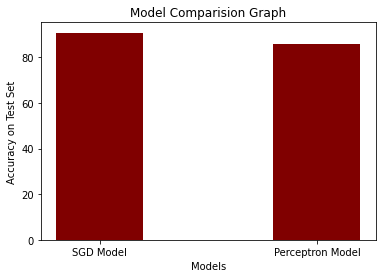

<Figure size 432x288 with 0 Axes>

In [18]:
train_model_run = suicide_func.run(name='train_model',
                                handler='train_model',
                                inputs={'input_ds': transform_dataset_run.outputs['suicide_dataset_transformed']},
                                local=True)

In [19]:
train_model_run.outputs

{'Accuracy on Perceptron Model': 85.96,
 'Accuracy on SGD Model': 90.73,
 'Model Comparision Graph': '/content/drive/MyDrive/Hackathon/Data/Model Comparision Graph.html',
 'Suicide_Model': 'store://artifacts/suicide-pred-root/train_model_Suicide_Model:bcb6e214bc7c401ebd020bd9819f97be'}

<h3> Serving 

In [20]:
serving = mlrun.code_to_function('seving', filename='Path of the Current Notebook', kind='serving')

serving.spec.default_class = 'SuicideModel'
serving.add_model('suicide-serving', train_model_run.outputs['Suicide_Model'])

In [21]:
my_data = '''{"inputs":["I'll kill myself am tired of living depressed and alone"]}'''

server = serving.to_mock_server()
server.test("/v2/models/suicide-serving/infer", body=my_data)

> 2021-07-06 10:42:58,758 [info] model suicide-serving was loaded
> 2021-07-06 10:42:58,760 [info] Loaded ['suicide-serving']


{'id': 'c2a5f63822964e6388c84ecdda896f71',
 'model_name': 'suicide-serving',
 'outputs': [1]}

In [22]:
my_data = '''{"inputs":["It's such a hot day, I'd like to have ice cream and visit the park"]}'''

server = serving.to_mock_server()
server.test("/v2/models/suicide-serving/infer", body=my_data)

> 2021-07-06 10:42:58,844 [info] model suicide-serving was loaded
> 2021-07-06 10:42:58,845 [info] Loaded ['suicide-serving']


{'id': '4ea284c5ed244db39771b2fa1964c2e0',
 'model_name': 'suicide-serving',
 'outputs': [0]}